In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Exercise 2

### Exercise 2a) Bias-Variance Tradeoff

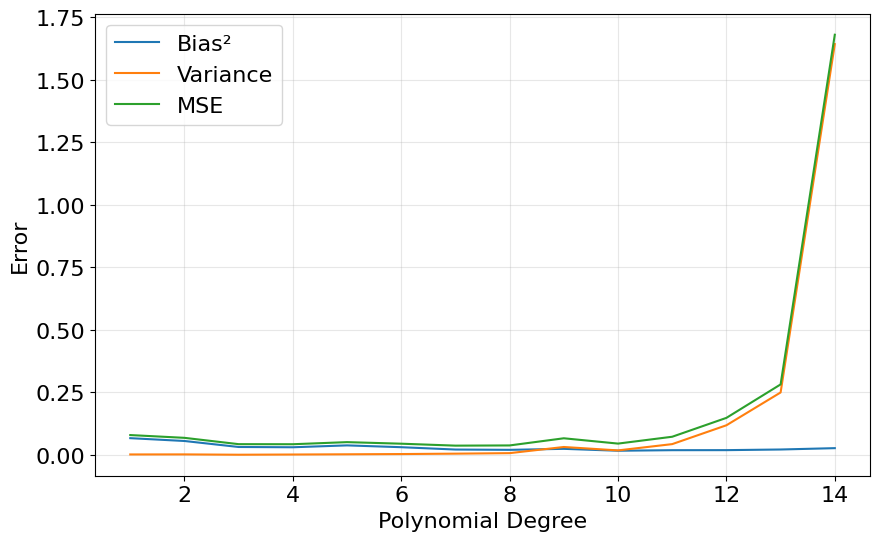

In [39]:
# Generate data
n = 100
bootstraps = 1000
x = np.linspace(-3, 3, n)
y = np.exp(-(x**2)) + 1.5 * np.exp(-((x - 2) ** 2)) + np.random.normal(0, 0.1, n)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    x.reshape(-1, 1), y, test_size=0.2, random_state=42
)

biases = []
variances = []
mses = []

# Loop over polynomial degrees
for p in range(1, 15):
    predictions = np.zeros((bootstraps, len(X_test)))
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=p)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    # Bootstrap loop
    for b in range(bootstraps):
        # Resample training data
        X_train_re, y_train_re = resample(X_train_poly, y_train, random_state=b)
        
        # Fit model
        model = LinearRegression()
        model.fit(X_train_re, y_train_re)
        
        # Predict on test set
        predictions[b, :] = model.predict(X_test_poly)
    
    # Calculate bias and variance
    mean_pred = np.mean(predictions, axis=0)
    bias_squared = np.mean((y_test - mean_pred)**2)
    variance = np.mean(np.var(predictions, axis=0))
    mse = bias_squared + variance + 0.01  # 0.01 = noise variance
    
    biases.append(bias_squared)
    variances.append(variance)
    mses.append(mse)

# Plot results
plt.figure(figsize=(10, 6))
degrees = range(1, 15)
plt.plot(degrees, biases, label='Bias²')
plt.plot(degrees, variances, label='Variance')
plt.plot(degrees, mses, label='MSE')
plt.xlabel('Polynomial Degree', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('bias_variance_tradeoff.pdf')
plt.show()

### Exercise 2d) Heatmap: MSE of Ridge Regression for varying λ and polynomial degree

In [35]:
def polynomial_features(x, p, intercept=False):
    n = len(x)
    
    if intercept:
        X = np.zeros((n, p + 1))
        X[:, 0] = 1
        for i in range(1, p + 1):  
            X[:, i] = x**i 
    else:
        X = np.zeros((n, p))
        X[:, 0] = x[:]
        for i in range(1, p):
            X[:, i] = x**(i+1)

    return X



def Ridge_parameters(X, y, lam):

    n = X.shape[1]
    return np.linalg.inv(X.T @ X + lam * np.eye(n)) @ X.T @ y

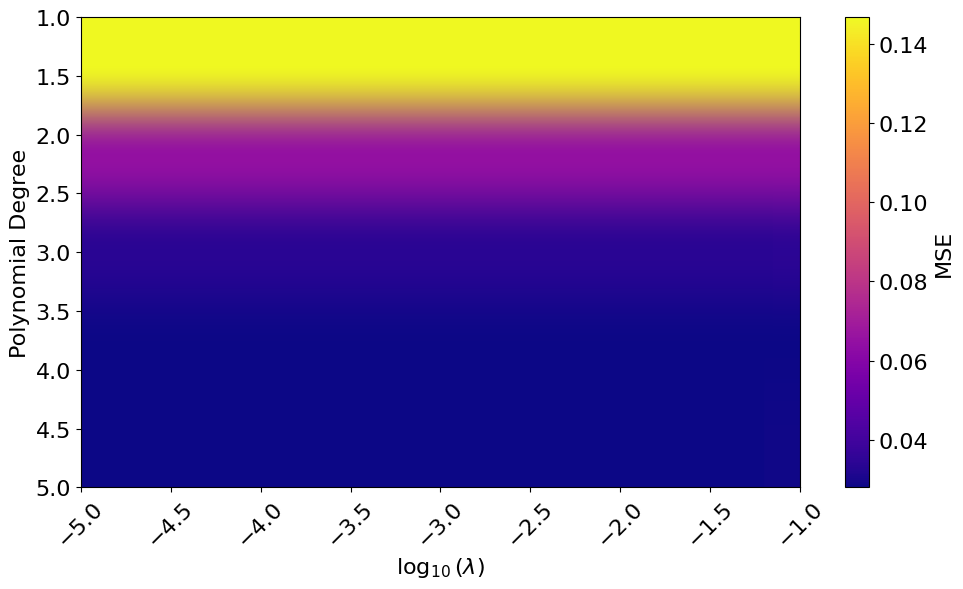

In [36]:
degrees = range(1, 6)
lambda_values = np.logspace(-5, -1, 1000)
test_mse_matrix = np.zeros((len(degrees), len(lambda_values)))


for i, deg in enumerate(degrees):
	X = polynomial_features(x, deg)
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
	
	scaler = StandardScaler()
	scaler.fit(X_train)
	X_train_s = scaler.transform(X_train)
	X_test_s = scaler.transform(X_test)
	y_offset = np.mean(y_train)

	y_train_centered = y_train - y_offset

	for j, l in enumerate(lambda_values):

		beta_lam_deg = Ridge_parameters(X_train_s, y_train_centered, lam=l)
		y_train_pred = X_train_s @ beta_lam_deg + y_offset
		y_test_pred = X_test_s @ beta_lam_deg + y_offset

		mse_test = mean_squared_error(y_test, y_test_pred)

		test_mse_matrix[i, j] = mse_test


plt.figure(figsize=(10, 6))
plt.imshow(test_mse_matrix, cmap='plasma', aspect='auto', \
		 extent=[np.log10(lambda_values[0]), np.log10(lambda_values[-1]), degrees[-1], degrees[0]])
cbar = plt.colorbar(label='MSE')
cbar.set_label('MSE', fontsize=16)
cbar.ax.tick_params(labelsize=16)

plt.xlabel(r'$\log_{10}(λ)$', fontsize=16)
plt.ylabel('Polynomial Degree', fontsize=16)
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('heatmap_ridge.pdf')
plt.show()